# Which club has the best staff?
Gabriel Lam

## Intent

Study player data from Division 1 European League* players from the last 5 Years. Analyze changes in player stats and value. Rank the clubs according to best increase in statistics of a player. Graphically represent the scores for the test set.

1. Does an increase in player spending create an increase in team rating?
2. Given a player’s age and starting skill level, what is the expected improvement?
3. How does a player’s ‘potential’ affect their future rating?

Details :
Sofifa Id, URL, Wage, Salary, Name, Real face, URL variables cannot be used during the prediction or learning.

1. Assign a score to all clubs out of 100, and represent it in an appropriate visualization. With 100 being the highest
2. For the test set, your model will be scored using MSE against the average of all models of the class. (Score = MSE( Your Values , Average of all models values))

The test set is as follows for this problem statement (Division 1 European League):
League =
- Premier League - English Premier League
- Bundesliga German 1. Bundesliga
- Ligue 1 French Ligue 1
- La Liga Spain Primera Division
- Serie A Italian Serie A



In [203]:
# imports and setups

import pandas as pd
import sklearn as sk
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
import numpy as np
import re
import seaborn as sns

from collections import defaultdict
import math
import random

from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras import callbacks

## Importing the Data

This pulls the necessary training and test data for initial work. This is based upon the player_data_cleaning notebook, which outputs these modified data files.

In [2]:
# import the cleaned data for FIFA19
p15_df = pd.read_csv('cleaned_data/players_15.csv')
p16_df = pd.read_csv('cleaned_data/players_16.csv')
p17_df = pd.read_csv('cleaned_data/players_17.csv')
p18_df = pd.read_csv('cleaned_data/players_18.csv')
p19_df = pd.read_csv('cleaned_data/players_19.csv')
p20_df = pd.read_csv('cleaned_data/players_20.csv')
league_df = pd.read_csv('cleaned_data/teams_and_leagues.csv')

C:\Users\lamga\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (30) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## Reviewing changes

Analyze changes in player stats and value. Rank the clubs according to best increase in statistics of a player. Graphically represent the scores for the test set.

To Do:
1. Categorize train and test sets
2. Find increase in statistics / values over 5 years
3. Use this ranking to assign score to each team
4. Predict the rankings for the test set


In [3]:
test_clubs = ["English Premier League ","Spain Primera Division ", "German 1. Bundesliga ","French Ligue 1 ","Italian Serie A"]

test_col = league_df[league_df["league_name"].isin(test_clubs)]["team"]
train_col = league_df[~league_df["league_name"].isin(test_clubs)]["team"]

## Selecting columns for train / test split:

Using a target set of columns to ensure that the data is not too convoluted during the learning / prediction process:

In [4]:
target_cols = ["overall","potential","value_eur","wage_eur","pace","shooting","dribbling",
               "defending","physic", "gk_diving","gk_handling","gk_kicking",
               "gk_reflexes", "gk_speed","gk_positioning"]

# target_cols = ["overall","potential","value_eur","pace","shooting","dribbling",
#                "defending","physic", "gk_diving","gk_handling","gk_kicking",
#                "gk_reflexes", "gk_speed","gk_positioning","attacking_crossing",
#               "attacking_finishing","attacking_heading_accuracy","attacking_short_passing",
#               "attacking_volleys","skill_dribbling","skill_curve","skill_fk_accuracy",
#                "skill_long_passing","skill_ball_control","movement_acceleration",
#               "movement_sprint_speed","movement_agility","movement_reactions","movement_balance",
#               "power_shot_power","power_jumping","power_stamina", "power_strength","power_long_shots"]

In [5]:
data_test_15 = p15_df[p15_df["club"].isin(test_col)][target_cols]
data_train_15 = p15_df[~p15_df["club"].isin(test_col)][target_cols]

data_test_16 = p16_df[p16_df["club"].isin(test_col)][target_cols]
data_train_16 = p16_df[~p16_df["club"].isin(test_col)][target_cols]

data_test_17 = p17_df[p17_df["club"].isin(test_col)][target_cols]
data_train_17 = p17_df[~p17_df["club"].isin(test_col)][target_cols]

data_test_18 = p18_df[p18_df["club"].isin(test_col)][target_cols]
data_train_18 = p18_df[~p18_df["club"].isin(test_col)][target_cols]

data_test_19 = p19_df[p19_df["club"].isin(test_col)][target_cols]
data_train_19 = p19_df[~p19_df["club"].isin(test_col)][target_cols]

data_test_20 = p20_df[p20_df["club"].isin(test_col)][target_cols]
data_train_20 = p20_df[~p20_df["club"].isin(test_col)][target_cols]

## Initial EDA:

Due to lack of data in player value in FIFA 15, I will not be including that dataset in the analysis of player statistics over the last 5 years.

In addition, I will focus on using the "overall" statistic growth first as a measure of how a club is ranked. Extract the team rating by averaging out the rating of all the players in the team. The value of the team will therefore be the sum of the total value of the players, and this will allow us to visualize the response of the change of rating with regards to a change of value.

**For each team:
    For each player:
        Find the overall statistic over last 5 years
        Find the value statistic over the last 5 years
        find the average increase to determine growth of overall
        find the average increase to determine growth of value
    average growth values and overall values for the entire team
    
find all growths for all teams

scale the distribution to 100 to see how the teams fare compared to the one with the highest growth**



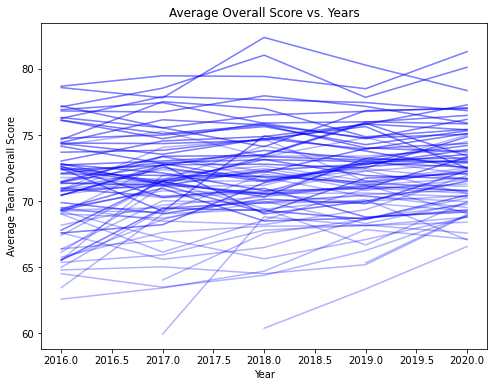

In [6]:
plt.figure(figsize=(8,6))
rate_growth_list = []
for team in test_col:
    year_list = np.arange(2016,2021)
    
    rating16 = p16_df.loc[p16_df["club"] == team]["overall"].mean()
    rating17 = p17_df.loc[p17_df["club"] == team]["overall"].mean()
    rating18 = p18_df.loc[p18_df["club"] == team]["overall"].mean()
    rating19 = p19_df.loc[p19_df["club"] == team]["overall"].mean()
    rating20 = p20_df.loc[p20_df["club"] == team]["overall"].mean()
    
    rating_list = [rating16,rating17,rating18,rating19,rating20]
    
    average = ((rating17-rating16)+(rating18-rating17)+(rating19-rating18)+(rating19-rating20))/4
    
    plt.plot(year_list,rating_list, label = team,linewidth = 1.5,alpha = 0.3,color = "b")
    
    rate_growth_list.append(np.mean(average))
    
# plt.legend()
plt.ylabel("Average Team Overall Score")
plt.xlabel("Year")
plt.title("Average Overall Score vs. Years")
plt.show()

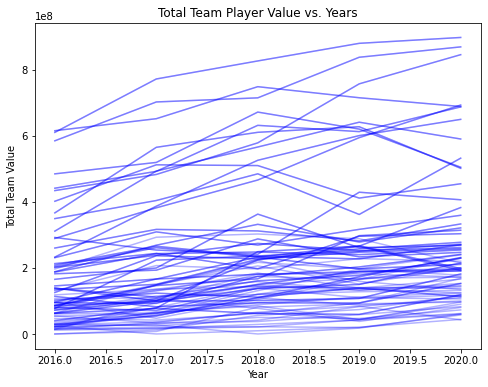

In [7]:
plt.figure(figsize=(8,6))

value_growth_list = []

for team in test_col:
    year_list = np.arange(2016,2021)
    
    value16 = p16_df.loc[p16_df["club"] == team]["value_eur"].sum()
    value17 = p17_df.loc[p17_df["club"] == team]["value_eur"].sum()
    value18 = p18_df.loc[p18_df["club"] == team]["value_eur"].sum()
    value19 = p19_df.loc[p19_df["club"] == team]["value_eur"].sum()
    value20 = p20_df.loc[p20_df["club"] == team]["value_eur"].sum()
    
    value_list = [value16,value17,value18,value19,value20]
    plt.plot(year_list,value_list, label = team,linewidth = 1.5,alpha = .3,color = "b")
    
    average = ((value17-value16)+(value18-value17)+(value19-value18)+(value19-value20))/4
    value_growth_list.append(np.mean(average))
    
# plt.legend()
plt.ylabel("Total Team Value")
plt.xlabel("Year")
plt.title("Total Team Player Value vs. Years")
plt.show()

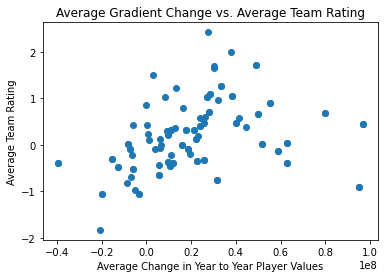

In [8]:
plt.scatter(value_growth_list,rate_growth_list)
plt.title("Average Gradient Change vs. Average Team Rating")
plt.ylabel("Average Team Rating")
plt.xlabel("Average Change in Year to Year Player Values")
plt.show()

## Baseline examination of club rankings

This first baseline defines a model by using delta-change in the mean overall rating of all members of the team over the last several years as predictors to determine which club produces the most drastic increase in team rating. This model looks solely at the historical trend of the team and utilizes them as datapoints to determine the rate of change as the response.


First we must produce copies of the league dataFrame such that the original dataFrame is not modified in some way. The first of the two dataFrames are for more extended investigation, whereas the latter contains solely the changes between years. These two dataFrames are then populated with the total sum of wages and total values of the players who are a part of the team, separated between each original FIFA yearly dataset.

In [9]:
df_1 = league_df.copy(deep=True)
df_rank = league_df.copy(deep=True)

In [10]:
#Initialize Lists and variables
wage16_list = []
wage17_list = []
wage18_list = []
wage19_list = []
wage20_list = []

value16_list = []
value17_list = []
value18_list = []
value19_list = []
value20_list = []

rating16_list = []
rating17_list = []
rating18_list = []
rating19_list = []
rating20_list = []

ovr_growth_1617 = []
ovr_growth_1718 = []
ovr_growth_1819 = []
ovr_growth_1920 = []

val_growth_1617 = []
val_growth_1718 = []
val_growth_1819 = []
val_growth_1920 = []

for team in league_df["team"]:
    wage16 = p16_df.loc[p16_df["club"] == team]["wage_eur"].sum()
    wage17 = p17_df.loc[p17_df["club"] == team]["wage_eur"].sum()
    wage18 = p18_df.loc[p18_df["club"] == team]["wage_eur"].sum()
    wage19 = p19_df.loc[p19_df["club"] == team]["wage_eur"].sum()
    wage20 = p20_df.loc[p20_df["club"] == team]["wage_eur"].sum()
    
    wage16_list.append(wage16)
    wage17_list.append(wage17)
    wage18_list.append(wage18)
    wage19_list.append(wage19)
    wage20_list.append(wage20)
    
    value16 = p16_df.loc[p16_df["club"] == team]["value_eur"].sum()
    value17 = p17_df.loc[p17_df["club"] == team]["value_eur"].sum()
    value18 = p18_df.loc[p18_df["club"] == team]["value_eur"].sum()
    value19 = p19_df.loc[p19_df["club"] == team]["value_eur"].sum()
    value20 = p20_df.loc[p20_df["club"] == team]["value_eur"].sum()
    
    value16_list.append(value16)
    value17_list.append(value17)
    value18_list.append(value18)
    value19_list.append(value19)
    value20_list.append(value20)
    
    rating16 = p16_df.loc[p16_df["club"] == team]["overall"].mean()
    rating17 = p17_df.loc[p17_df["club"] == team]["overall"].mean()
    rating18 = p18_df.loc[p18_df["club"] == team]["overall"].mean()
    rating19 = p19_df.loc[p19_df["club"] == team]["overall"].mean()
    rating20 = p20_df.loc[p20_df["club"] == team]["overall"].mean()

    rating16_list.append(rating16)
    rating17_list.append(rating17)
    rating18_list.append(rating18)
    rating19_list.append(rating19)
    rating20_list.append(rating20)
    
    ovr_growth_1617.append(rating17-rating16)
    ovr_growth_1718.append(rating18-rating17)
    ovr_growth_1819.append(rating19-rating18)
    ovr_growth_1920.append(rating20-rating19)
    
    val_growth_1617.append(value17-value16)
    val_growth_1718.append(value18-value17)
    val_growth_1819.append(value19-value18)
    val_growth_1920.append(value20-value19)

In [184]:
# place total wage, total value, and average team rating into one dataFrame
    
df_1["total team wages 2016"] = wage16_list
df_1["total team wages 2017"] = wage17_list
df_1["total team wages 2018"] = wage18_list
df_1["total team wages 2019"] = wage19_list
df_1["total team wages 2020"] = wage20_list

df_1["total team value 2016"] = value16_list
df_1["total team value 2017"] = value17_list
df_1["total team value 2018"] = value18_list
df_1["total team value 2019"] = value19_list
df_1["total team value 2020"] = value20_list

df_1["avg team rating 2016"] = rating16_list
df_1["avg team rating 2017"] = rating17_list
df_1["avg team rating 2018"] = rating18_list
df_1["avg team rating 2019"] = rating19_list
df_1["avg team rating 2020"] = rating20_list

df_1["rating delta 16-17"] = df_rank["rating delta 16-17"].fillna(0)
df_1["rating delta 17-18"] = df_rank["rating delta 17-18"].fillna(0)
df_1["rating delta 18-19"] = df_rank["rating delta 18-19"].fillna(0)
df_1["rating delta 19-20"] = df_rank["rating delta 19-20"].fillna(0)

# place value and ovr rating changes in ranking dataFrame

df_rank["rating delta 16-17"] = ovr_growth_1617
df_rank["rating delta 17-18"] = ovr_growth_1718
df_rank["rating delta 18-19"] = ovr_growth_1819
df_rank["rating delta 19-20"] = ovr_growth_1920

df_rank["value delta 16-17"] = val_growth_1617
df_rank["value delta 17-18"] = val_growth_1718
df_rank["value delta 18-19"] = val_growth_1819
df_rank["value delta 19-20"] = val_growth_1920

# separate test and train dataFrames

df_1_test = df_1[df_1["league_name"].isin(test_clubs)].drop(["Unnamed: 0"],axis = 1)
df_1_train = df_1[~df_1["league_name"].isin(test_clubs)].drop(["Unnamed: 0"],axis = 1)

# ONLY test set needed for club rankings as per project guidelines

df_rank_test = df_rank[df_rank["league_name"].isin(test_clubs)].drop(["Unnamed: 0"],axis = 1)
df_rank_train = df_rank[~df_rank["league_name"].isin(test_clubs)].drop(["Unnamed: 0"],axis = 1)

Due to the fact that teams will continue to change, and the makeup of each league (in particular the division 1 leagues that are a part of the test set as specified by the project guideline) will not contain data for each club for all of the years. This means that there needs to be data that is filled in - the value here is 0 because we are assuming that there is no change in rating / wage / value to simplify data collection.

Afterwards, a series of subplots are produced to visualize a preliminary model to determine the rate of change for each team. Using a Linear Regression model here gives us the fastest and most legible method for determination.

In [185]:
df_2 = df_rank_test.fillna(0)

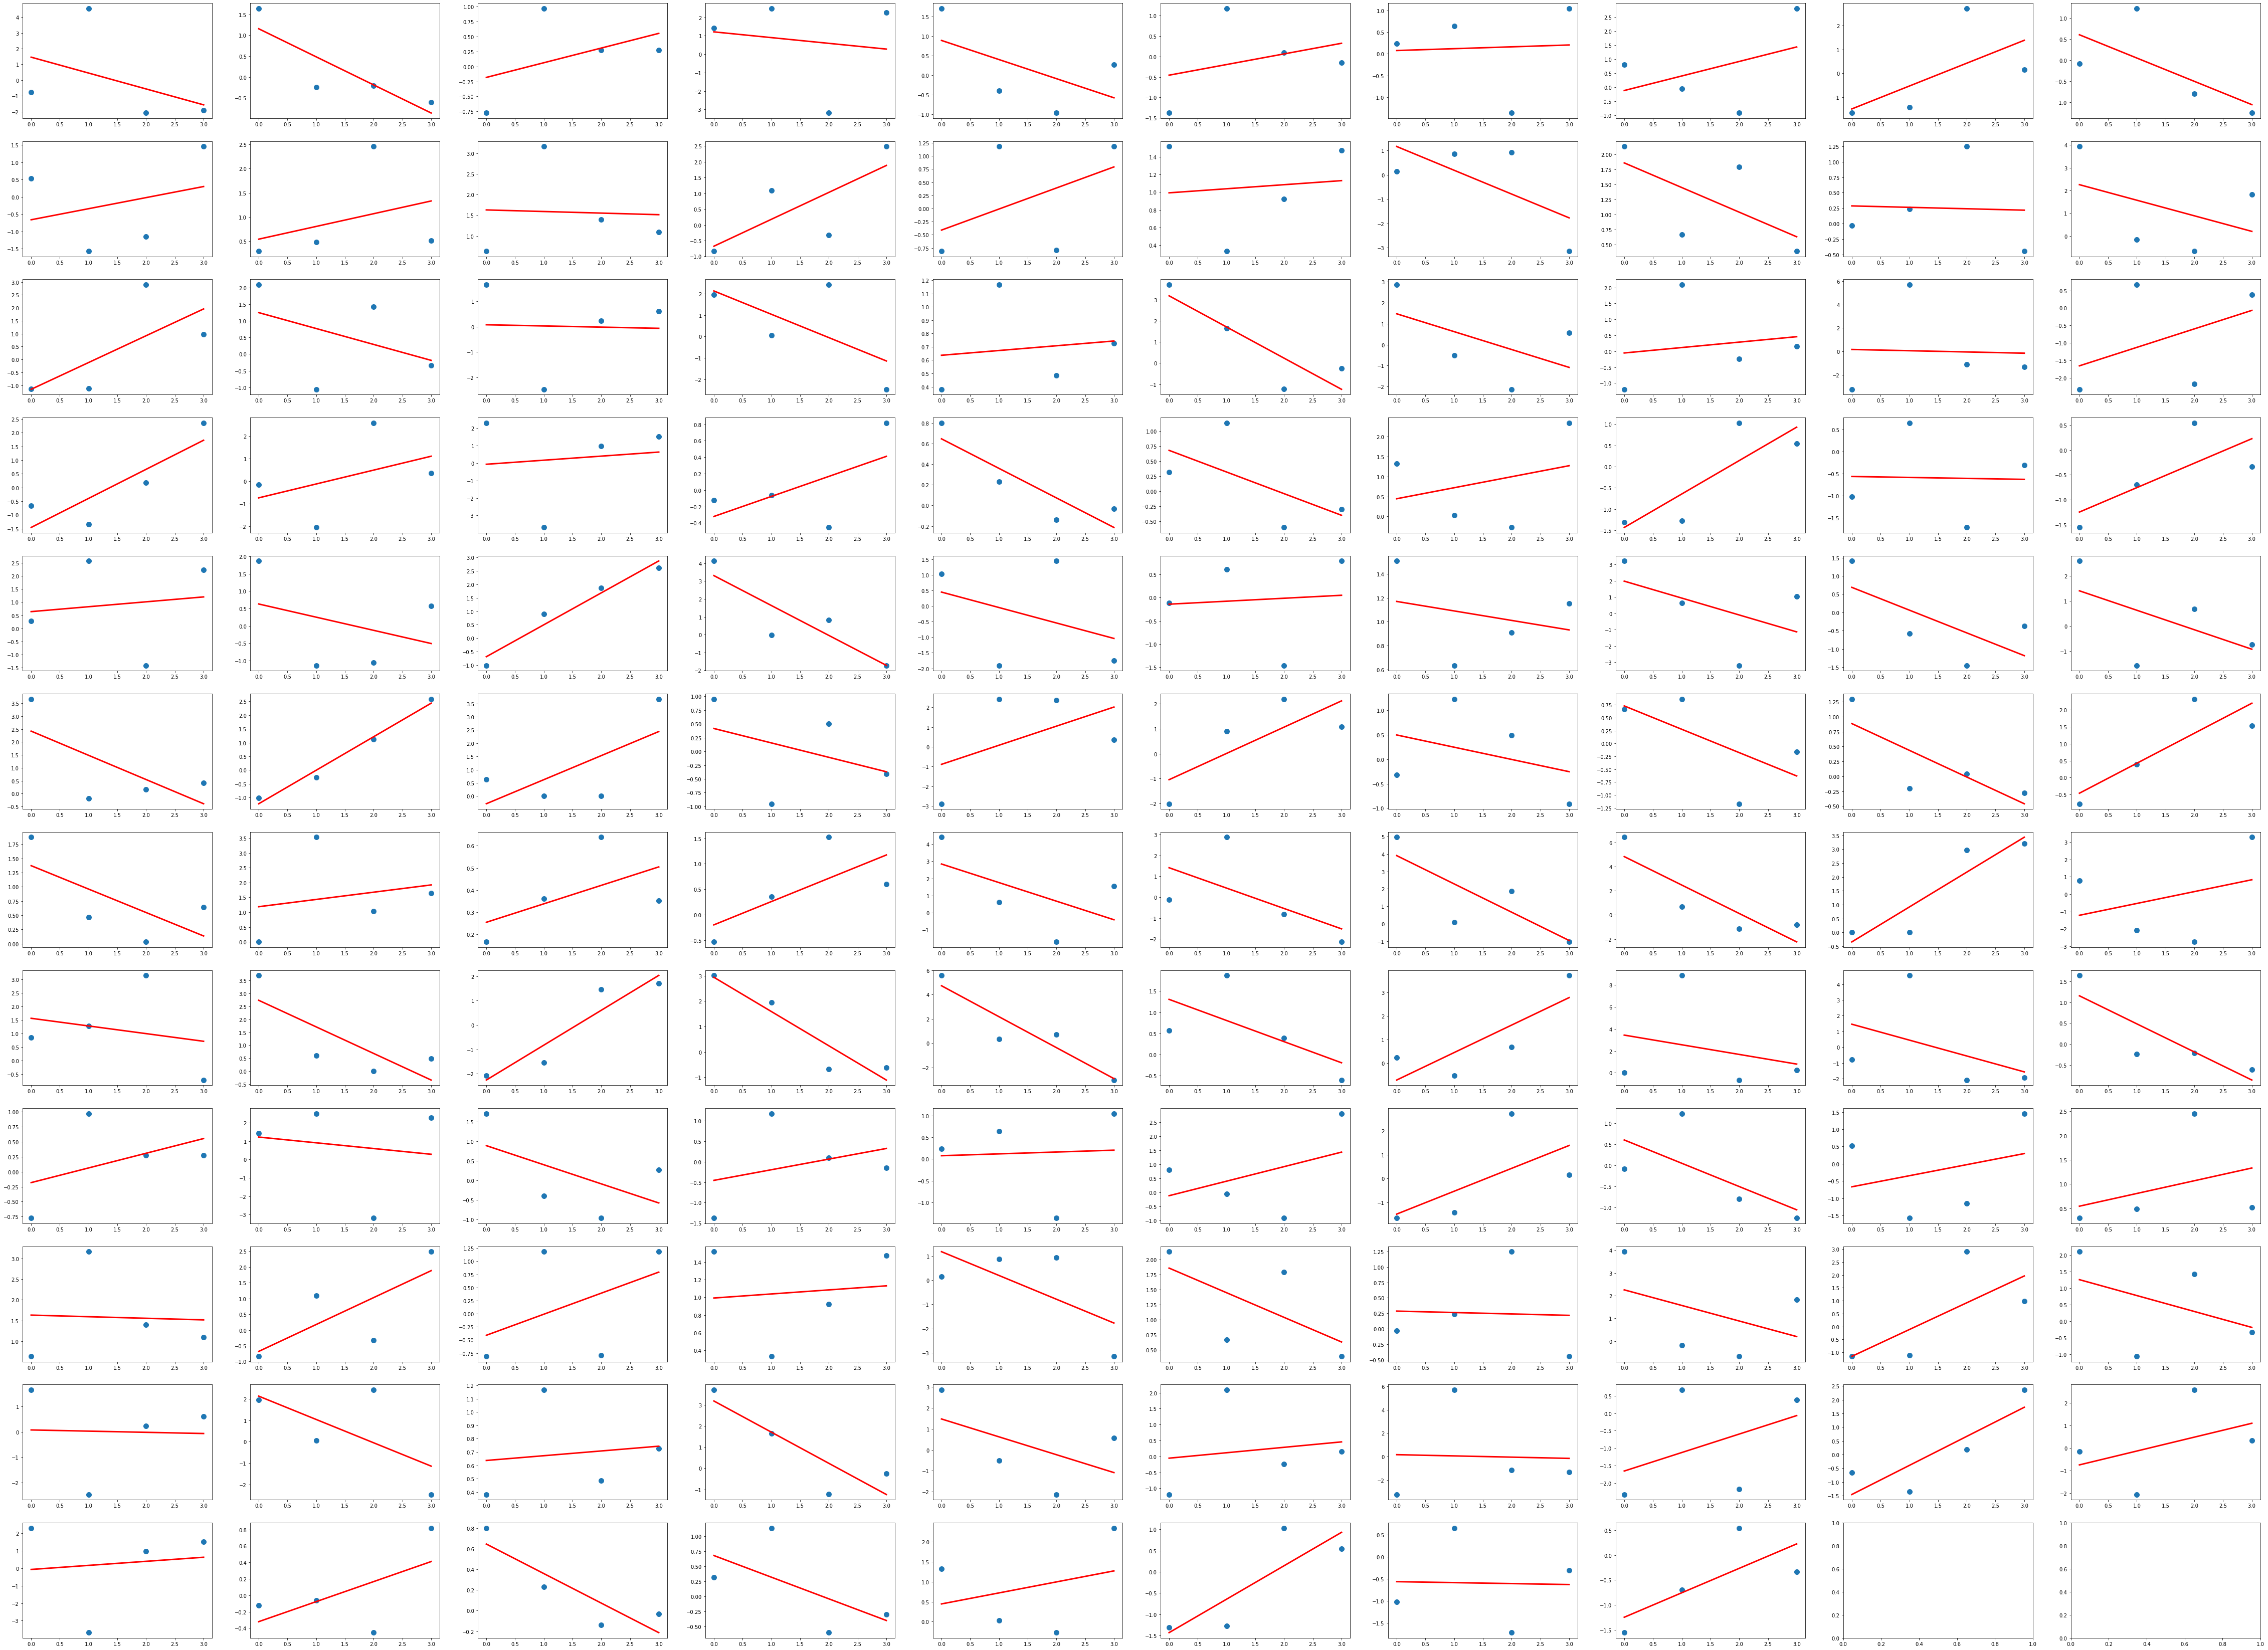

In [186]:
# fig, axs = plt.subplots(df_rank_test.shape[0],figsize=(15,15))
fig, axs = plt.subplots(12,10,figsize = (80,60))
count = 0
coef_list = []
for row in df_2.iterrows():
    ovr_change = np.array([row[1][3],row[1][4],row[1][5],row[1][6]])
    
    
    x_temp = np.array(range(0,4))
    lr = LinearRegression().fit(x_temp.reshape(-1,1),ovr_change)
    
#     lr = LinearRegression().fit(ovr_change.reshape(1,-1),df_1["avg team rating 2020"][count])
    
    coef = lr.coef_[0]
    coef_list.append(coef)
    
    ovr_pred = lr.predict(x_temp.reshape(-1,1))
    
    num_row = count // 10
    num_col = count % 10
    axs[num_row][num_col].scatter(x_temp,ovr_change, s = 100)
    axs[num_row][num_col].plot(x_temp,ovr_pred ,color = "red",linewidth = 3)
    
    count += 1
    #     plt.figure(figsize=(4,2))
#     plt.scatter(ovr_change,np.array(range(0,4)))
#     plt.show()

In [187]:
max_idx = np.argmax(coef_list)
best_club = df_2.iloc[max_idx]["team"]

print(f'The best club based on this baseline was {best_club}.')

The best club based on this baseline was Stade de Reims.


## Train / Test Split

Here the train and test sets are split based on the assigned specification of European Division 1 League clubs, and the training set is all other teams. The average team rating for teams without a rating in a specific year is assumed to be 0 at this point.

In [188]:
df_1_train = df_1_train.fillna(0)
df_1_test = df_1_test.fillna(0)

In [229]:
# Xtrain_16 = df_1_train[["total team wages 2016","total team value 2016"]]
# Xtrain_17 = df_1_train[["total team wages 2017","total team value 2017"]]
# Xtrain_18 = df_1_train[["total team wages 2018","total team value 2018"]]
# Xtrain_19 = df_1_train[["total team wages 2019","total team value 2019"]]
# Xtrain_20 = df_1_train[["total team wages 2020","total team value 2020"]]

# ytrain_16 = df_1_train["avg team rating 2016"].fillna(0)
# ytrain_17 = df_1_train["avg team rating 2017"].fillna(0)
# ytrain_18 = df_1_train["avg team rating 2018"].fillna(0)
# ytrain_19 = df_1_train["avg team rating 2019"].fillna(0)
# ytrain_20 = df_1_train["avg team rating 2020"].fillna(0)


In [242]:
Xtrain_17 = df_1_train[["total team wages 2017","total team value 2017","rating delta 16-17"]]
Xtrain_18 = df_1_train[["total team wages 2018","total team value 2018","rating delta 17-18"]]
Xtrain_19 = df_1_train[["total team wages 2019","total team value 2019","rating delta 18-19"]]
Xtrain_20 = df_1_train[["total team wages 2020","total team value 2020","rating delta 19-20"]]
ytrain_17 = df_1_train["avg team rating 2017"]
ytrain_18 = df_1_train["avg team rating 2018"]
ytrain_19 = df_1_train["avg team rating 2019"]
ytrain_20 = df_1_train["avg team rating 2020"]

In [243]:
# Xtrain_17 = df_1_train[["total team wages 2017","total team value 2017","avg team rating 2017"]]
# Xtrain_18 = df_1_train[["total team wages 2018","total team value 2018","avg team rating 2018"]]
# Xtrain_19 = df_1_train[["total team wages 2019","total team value 2019","avg team rating 2019"]]
# Xtrain_20 = df_1_train[["total team wages 2020","total team value 2020","avg team rating 2020"]]

# ytrain_17 = df_1_train["rating delta 16-17"]
# ytrain_18 = df_1_train["rating delta 17-18"]
# ytrain_19 = df_1_train["rating delta 18-19"]
# ytrain_20 = df_1_train["rating delta 19-20"]

In [244]:
# Xtest_16 = df_1_test[["total team wages 2016","total team value 2016"]]
# ytest_16 = df_1_test["avg team rating 2016"].fillna(0)

# Xtest_17 = df_1_test[["total team wages 2017","total team value 2017"]]
# ytest_17 = df_1_test["avg team rating 2017"].fillna(0)

# Xtest_18 = df_1_test[["total team wages 2018","total team value 2018"]]
# ytest_18 = df_1_test["avg team rating 2018"].fillna(0)

# Xtest_19 = df_1_test[["total team wages 2019","total team value 2019"]]
# ytest_19 = df_1_test["avg team rating 2019"].fillna(0)

# Xtest_20 = df_1_test[["total team wages 2020","total team value 2020"]]
# ytest_20 = df_1_test["avg team rating 2020"].fillna(0)

In [245]:
Xtest_17 = df_1_test[["total team wages 2017","total team value 2017","rating delta 16-17"]]
ytest_17 = df_1_test["avg team rating 2017"]

Xtest_18 = df_1_test[["total team wages 2018","total team value 2018","rating delta 17-18"]]
ytest_18 = df_1_test["avg team rating 2018"]

Xtest_19 = df_1_test[["total team wages 2019","total team value 2019","rating delta 18-19"]]
ytest_19 = df_1_test["avg team rating 2019"]

Xtest_20 = df_1_test[["total team wages 2020","total team value 2020","rating delta 19-20"]]
ytest_20 = df_1_test["avg team rating 2020"]

In [192]:
# Xtest_16 = df_1_test[["total team wages 2016","total team value 2016","avg team rating 2016"]]
# ytest_16 = df_rank_test["avg team rating 2016"].fillna(0)

# Xtest_17 = df_1_test[["total team wages 2017","total team value 2017","avg team rating 2017"]]
# ytest_17 = df_1_test["rating delta 16-17"]

# Xtest_18 = df_1_test[["total team wages 2018","total team value 2018","avg team rating 2018"]]
# ytest_18 = df_1_test["rating delta 17-18"]

# Xtest_19 = df_1_test[["total team wages 2019","total team value 2019","avg team rating 2019"]]
# ytest_19 = df_1_test["rating delta 18-19"]

# Xtest_20 = df_1_test[["total team wages 2020","total team value 2020","avg team rating 2020"]]
# ytest_20 = df_1_test["rating delta 19-20"]

## Scale the Data

Data is scaled so that values are not skewed due to their magnitudes.

In [254]:
# Xtest_17_scaled = np.nan_to_num(scalerX.transform(Xtest_17))
# Xtest_18_scaled = np.nan_to_num(scalerX.transform(Xtest_18))
# Xtest_19_scaled = np.nan_to_num(scalerX.transform(Xtest_19))
# Xtest_20_scaled = np.nan_to_num(scalerX.transform(Xtest_20))

In [246]:
scalerX = StandardScaler()
scalerX.fit(Xtrain_20)

# Xtrain_16_scaled = scalerX.transform(Xtrain_16)
Xtrain_17_scaled = scalerX.transform(Xtrain_17)
Xtrain_18_scaled = scalerX.transform(Xtrain_18)
Xtrain_19_scaled = scalerX.transform(Xtrain_19)
Xtrain_20_scaled = scalerX.transform(Xtrain_20)


# Xtest_16_scaled = scalerX.transform(Xtest_16)
Xtest_17_scaled = scalerX.transform(Xtest_17)
Xtest_18_scaled = scalerX.transform(Xtest_18)
Xtest_19_scaled = scalerX.transform(Xtest_19)
Xtest_20_scaled = scalerX.transform(Xtest_20)


## Model construction

Using bagging and decision trees with cross validation we can determine the optimal depth of the tree for each year. This will show us how to produce a model that can fit as many years as possible while also ensuring that the model is not overfit for any particular year.

In [247]:
depths = range(20, 50, 2)
# scores16 = []
scores17 = []
scores18 = []
scores19 = []
scores20 = []
mean_scores = []

for depth in depths:
    print(f'Evaluating depth of {depth}...')
    dec_tree = DecisionTreeRegressor(max_depth=depth)
    bagger = BaggingRegressor(dec_tree, n_estimators=100)
    
#     result16 = cross_validate(bagger, Xtrain_16_scaled, ytrain_16.values, scoring='neg_mean_squared_error', cv=5,n_jobs=4)
#     score16 = np.abs(np.mean(result16["test_score"]))/6
#     scores16.append(score16)
#     print(f'Saved score for 2016 of {score16:.5f}.')
    
    result17 = cross_validate(bagger, Xtrain_17_scaled, ytrain_17.values, scoring='neg_mean_squared_error', cv=5,n_jobs=4)
    score17 = np.abs(np.mean(result17["test_score"]))
    scores17.append(score17)
    print(f'Saved score for 2017 of {score17:.5f}.')
    
    result18 = cross_validate(bagger, Xtrain_18_scaled, ytrain_18.values, scoring='neg_mean_squared_error', cv=5,n_jobs=4)
    score18 = np.abs(np.mean(result18["test_score"]))
    scores18.append(score18)
    print(f'Saved score for 2018 of {score18:.5f}.')
    
    result19 = cross_validate(bagger, Xtrain_19_scaled, ytrain_19.values, scoring='neg_mean_squared_error', cv=5,n_jobs=4)
    score19 = np.abs(np.mean(result19["test_score"]))
    scores19.append(score19)
    print(f'Saved score for 2019 of {score19:.5f}.')
    
    result20 = cross_validate(bagger, Xtrain_20_scaled, ytrain_20.values, scoring='neg_mean_squared_error', cv=5,n_jobs=4)
    score20 = np.abs(np.mean(result20["test_score"]))
    scores20.append(score20)
    print(f'Saved score for 2020 of {score20:.5f}.')
    
    mean_scores.append(np.mean([score16,score17,score18,score19,score20]))

Evaluating depth of 20...
Saved score for 2017 of 0.95126.
Saved score for 2018 of 0.95402.
Saved score for 2019 of 1.37409.
Saved score for 2020 of 1.48799.
Evaluating depth of 22...
Saved score for 2017 of 0.91149.
Saved score for 2018 of 0.95767.
Saved score for 2019 of 1.37501.
Saved score for 2020 of 1.45691.
Evaluating depth of 24...
Saved score for 2017 of 0.87853.
Saved score for 2018 of 0.95839.
Saved score for 2019 of 1.39415.
Saved score for 2020 of 1.45306.
Evaluating depth of 26...
Saved score for 2017 of 0.94986.
Saved score for 2018 of 0.98661.
Saved score for 2019 of 1.38803.
Saved score for 2020 of 1.46919.
Evaluating depth of 28...
Saved score for 2017 of 0.96450.
Saved score for 2018 of 0.95559.
Saved score for 2019 of 1.41401.
Saved score for 2020 of 1.47495.
Evaluating depth of 30...
Saved score for 2017 of 0.87888.
Saved score for 2018 of 0.97399.
Saved score for 2019 of 1.38090.
Saved score for 2020 of 1.53432.
Evaluating depth of 32...
Saved score for 2017 of 0.

In [248]:

min_idx = np.argmin(mean_scores)
best_depth = depths[min_idx]
best_score = mean_scores[min_idx]

print(f'The best depth was {best_depth} with a score of {best_score:.5f}.')

The best depth was 24 with a score of 1.04393.


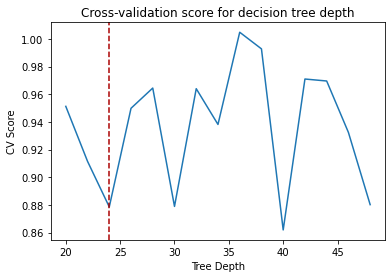

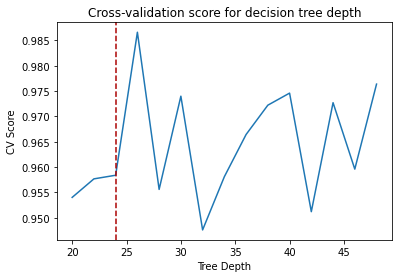

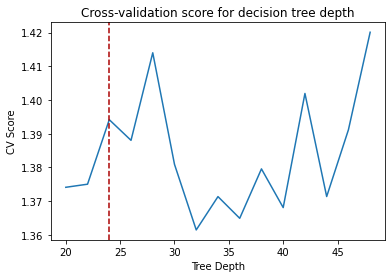

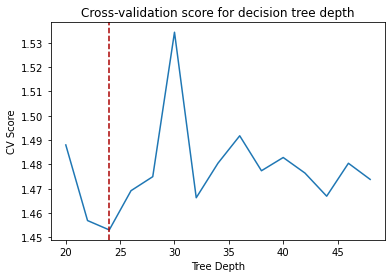

In [249]:
# score_list = [scores16,scores17,scores18,scores19,scores20]

score_list = [scores17,scores18,scores19,scores20]

for i in range(len(score_list)):
    
    plt.plot(depths, score_list[i])
    plt.axvline(x=best_depth, color='#AA0000', linestyle='--')
    plt.xlabel('Tree Depth')
    plt.ylabel('CV Score')
    plt.title('Cross-validation score for decision tree depth')
    plt.show()

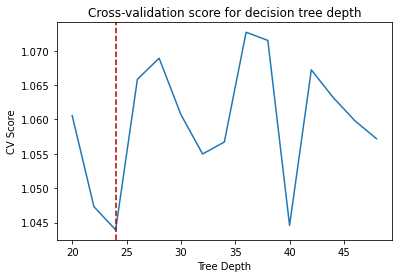

In [250]:
plt.plot(depths, mean_scores)
plt.axvline(x=best_depth, color='#AA0000', linestyle='--')
plt.xlabel('Tree Depth')
plt.ylabel('CV Score')
plt.title('Cross-validation score for decision tree depth')
plt.show()

In [251]:
dec_tree = DecisionTreeRegressor(max_depth=best_depth)
bagger16 = BaggingRegressor(dec_tree, n_estimators=100)
bagger16.fit(Xtrain_16_scaled, ytrain_16)

bagger17 = BaggingRegressor(dec_tree, n_estimators=100)
bagger17.fit(Xtrain_17_scaled, ytrain_17)

bagger18 = BaggingRegressor(dec_tree, n_estimators=100)
bagger18.fit(Xtrain_18_scaled, ytrain_18)

bagger19 = BaggingRegressor(dec_tree, n_estimators=100)
bagger19.fit(Xtrain_19_scaled, ytrain_19)

bagger20 = BaggingRegressor(dec_tree, n_estimators=100)
bagger20.fit(Xtrain_20_scaled, ytrain_20)

BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=24),
                 n_estimators=100)

In [256]:
y_pred_17 = bagger20.predict(Xtest_17_scaled)
y_pred_18 = bagger20.predict(Xtest_18_scaled)
y_pred_19 = bagger20.predict(Xtest_19_scaled)
y_pred_20 = bagger20.predict(Xtest_20_scaled)

mse17 = mean_squared_error(ytest_17,y_pred_17)
mse18 = mean_squared_error(ytest_18,y_pred_18)
mse19 = mean_squared_error(ytest_19,y_pred_19)
mse20 = mean_squared_error(ytest_20,y_pred_20)

# print(f'The final model is {accuracy16:.5f} accurate on the FIFA16 set.')
print(f'The final model has an MSE of {mse17:.5f} on the FIFA17 set.')
print(f'The final model has an MSE of {mse18:.5f} on the FIFA18 set.')
print(f'The final model has an MSE of {mse19:.5f} on the FIFA19 set.')
print(f'The final model has an MSE of {mse20:.5f} on the FIFA20 set.')

The final model has an MSE of 1.96829 on the FIFA17 set.
The final model has an MSE of 2.43463 on the FIFA18 set.
The final model has an MSE of 1.85261 on the FIFA19 set.
The final model has an MSE of 2.09332 on the FIFA20 set.


In [253]:
# accuracy16 = bagger20.score(Xtest_16_scaled, ytest_16)
accuracy17 = bagger20.score(Xtest_17_scaled, ytest_17)
accuracy18 = bagger20.score(Xtest_18_scaled, ytest_18)
accuracy19 = bagger20.score(Xtest_19_scaled, ytest_19)
accuracy20 = bagger20.score(Xtest_20_scaled, ytest_20)

# print(f'The final model is {accuracy16:.5f} accurate on the FIFA16 set.')
print(f'The final model has an R^2 score of {accuracy17:.5f} on the FIFA17 set.')
print(f'The final model has an R^2 score of {accuracy18:.5f} on the FIFA18 set.')
print(f'The final model has an R^2 score of {accuracy19:.5f} on the FIFA19 set.')
print(f'The final model has an R^2 score of {accuracy20:.5f} on the FIFA20 set.')

The final model has an R^2 score of 0.96488 on the FIFA17 set.
The final model has an R^2 score of 0.95757 on the FIFA18 set.
The final model has an R^2 score of 0.82065 on the FIFA19 set.
The final model has an R^2 score of 0.76631 on the FIFA20 set.


In [241]:
display(df_rank_test.sort_values(by=['rating delta 19-20'])["team"].head(5))

1043    FC Schalke 04
23      FC Schalke 04
231         Dijon FCO
1052       Real Betis
32         Real Betis
Name: team, dtype: object

In [264]:
max_idx = np.argmax(y_pred_20)
best_team = df_1_test.iloc[max_idx]["team"]
print(f"The team predicted to have the highest rating based on last year alone is {best_team}.")

The team predicted to have the highest rating based on last year alone is FC Barcelona.


# Supplementary Model Attempts and Experiments

## Neural Network

Data processing and new dataframe construction that utilizes a concatenated version of all years' data.
Two sets are done - 

In [24]:
# Xtrain_NN = df_1_train[[
#                         "total team wages 2016",
#                         "total team value 2016",
#                         "total team wages 2017",
#                         "total team value 2017",
#                         "total team wages 2018",
#                         "total team value 2018",
#                         "total team wages 2019",
#                         "total team value 2019",
#                         "total team wages 2020",
#                         "total team value 2020",
# #                         "avg team rating 2016",
# #                         "avg team rating 2017",
# #                         "avg team rating 2018",
# #                         "avg team rating 2019",
# #                         "avg team rating 2020"]]
#                        ]]

# Xtest_NN = df_1_test[[
#                         "total team wages 2016",
#                         "total team value 2016",
#                         "total team wages 2017",
#                         "total team value 2017",
#                         "total team wages 2018",
#                         "total team value 2018",
#                         "total team wages 2019",
#                         "total team value 2019",
#                         "total team wages 2020",
#                         "total team value 2020",
#                        ]]

# scalerX_NN = StandardScaler()
# scalerX_NN.fit(Xtrain_NN)
# Xtrain_NN_scaled = scalerX_NN.transform(Xtrain_NN)
# Xtest_NN_scaled = scalerX_NN.transform(Xtest_NN)

In [25]:
df_3 = df_rank_train.fillna(0)

In [33]:
df_train_NN = pd.DataFrame()

df_train_NN["total wage"] = Xtrain_17["total team wages 2017"]
df_train_NN["total value"] = Xtrain_17["total team value 2017"]
df_train_NN["team rating"] = ytrain_17
df_train_NN["value delta"] = df_3["value delta 16-17"]
df_train_NN["rating delta"] = df_3["rating delta 16-17"]



temp = pd.DataFrame()

temp["total wage"] = Xtrain_18["total team wages 2018"]
temp["total value"] = Xtrain_18["total team value 2018"]
temp["team rating"] = ytrain_18
temp["value delta"] = df_3["value delta 17-18"]
temp["rating delta"] = df_3["rating delta 17-18"]

df_train_NN = df_train_NN.append(temp)

temp = pd.DataFrame()

temp["total wage"] = Xtrain_19["total team wages 2019"]
temp["total value"] = Xtrain_19["total team value 2019"]
temp["team rating"] = ytrain_19
temp["value delta"] = df_3["value delta 18-19"]
temp["rating delta"] = df_3["rating delta 18-19"]

df_train_NN = df_train_NN.append(temp)

temp = pd.DataFrame()

temp["total wage"] = Xtrain_20["total team wages 2020"]
temp["total value"] = Xtrain_20["total team value 2020"]
temp["team rating"] = ytrain_20
temp["value delta"] = df_3["value delta 18-19"]
temp["rating delta"] = df_3["rating delta 19-20"]

df_train_NN = df_train_NN.append(temp)

ytrain_NN = df_train_NN["rating delta"]

In [39]:
df_test_NN = pd.DataFrame()

df_test_NN["total wage"] = Xtest_17["total team wages 2017"]
df_test_NN["total value"] = Xtest_17["total team value 2017"]
df_test_NN["team rating"] = ytest_17
df_test_NN["value delta"] = df_2["value delta 16-17"]
df_test_NN["rating delta"] = df_2["rating delta 16-17"]


temp = pd.DataFrame()

temp["total wage"] = Xtest_18["total team wages 2018"]
temp["total value"] = Xtest_18["total team value 2018"]
temp["team rating"] = ytest_18
temp["value delta"] = df_2["value delta 17-18"]
temp["rating delta"] = df_2["rating delta 17-18"]

df_test_NN = df_test_NN.append(temp)

temp = pd.DataFrame()

temp["total wage"] = Xtest_19["total team wages 2019"]
temp["total value"] = Xtest_19["total team value 2019"]
temp["team rating"] = ytest_19
temp["value delta"] = df_2["value delta 18-19"]
temp["rating delta"] = df_2["rating delta 18-19"]

df_test_NN = df_test_NN.append(temp)

temp = pd.DataFrame()

temp["total wage"] = Xtest_20["total team wages 2020"]
temp["total value"] = Xtest_20["total team value 2020"]
temp["team rating"] = ytest_20
temp["value delta"] = df_2["value delta 18-19"]
temp["rating delta"] = df_2["rating delta 19-20"]

df_test_NN = df_test_NN.append(temp)

ytest_NN = df_test_NN["rating delta"]

In [35]:
Xtrain_NN = df_train_NN[["total wage","total value","team rating","value delta"]]
Xtest_NN = df_test_NN[["total wage","total value","team rating","value delta"]]

scalerX_NN = StandardScaler()
scalerX_NN.fit(Xtrain_NN)
Xtrain_NN_scaled = scalerX_NN.transform(Xtrain_NN)
Xtest_NN_scaled = scalerX_NN.transform(Xtest_NN)

In [36]:
tf.random.set_seed(42)

kernel_weight = 0.0001

#reset the model 
NN_model = tf.keras.models.Sequential()

# input layers 
NN_model.add(tf.keras.layers.Dense(units=100,
                                   input_shape=(Xtrain_NN.shape[1],),
                                   activation = 'relu', 
                                   kernel_regularizer=regularizers.l1(kernel_weight),
                                   ))

NN_model.add(tf.keras.layers.Dense(units=50, activation = 'relu'))
NN_model.add(tf.keras.layers.Dense(units=50, activation = 'relu'))
NN_model.add(tf.keras.layers.Dense(units=50, activation = 'relu'))
NN_model.add(tf.keras.layers.Dense(units=30, activation = 'relu'))


# output layer 
NN_model.add(tf.keras.layers.Dense(1,  activation='linear'))

# Summary 
NN_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 100)               500       
_________________________________________________________________
dense_7 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_8 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_9 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_10 (Dense)             (None, 30)                1530      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 31        
Total params: 12,211
Trainable params: 12,211
Non-trainable params: 0
__________________________________________________

In [37]:
batch_size = 128
epochs = 1000
learning_rate = 0.01

optimizer = tf.keras.optimizers.Adam(learning_rate)

NN_model.compile(
                 optimizer=optimizer,
                 loss='mse',
                 metrics=['accuracy']
)

# fit it 
history = NN_model.fit(Xtrain_NN_scaled,
                        ytrain_NN, 
                        batch_size=batch_size, 
                        epochs=epochs,  
                        validation_split=.3, 
                        verbose=0)

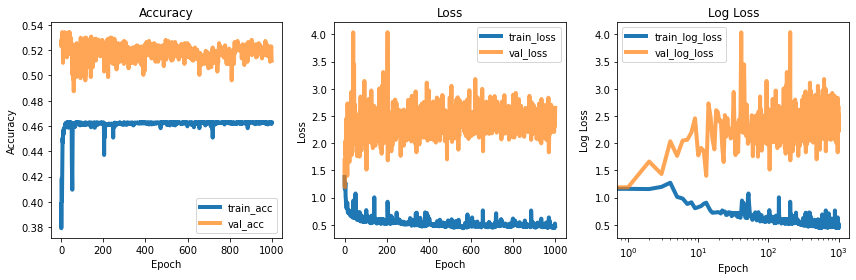

In [38]:
def plot_accuracy(model_history, key='accuracy'):
    plt.figure(figsize=[12,4])
    
    plt.subplot(1,3,1)
    plt.plot(model_history.history[f'{key}'], label = 'train_acc', linewidth=4)
    plt.plot(model_history.history[f'val_{key}'], label = 'val_acc', linewidth=4, alpha=.7)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title("Accuracy")
    plt.legend(loc='best')
    
    plt.subplot(1,3,2)
    plt.plot(model_history.history[f'loss'], label = 'train_loss', linewidth=4)
    plt.plot(model_history.history[f'val_loss'], label = 'val_loss', linewidth=4, alpha=.7)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title("Loss")
    plt.legend(loc='best')
    
    plt.subplot(1,3,3)
    plt.semilogx(model_history.history[f'loss'], label = 'train_log_loss', linewidth=4)
    plt.semilogx(model_history.history[f'val_loss'], label = 'val_log_loss', linewidth=4, alpha=.7)
    plt.xlabel('Epoch')
    plt.ylabel('Log Loss')
    plt.title("Log Loss")
    plt.legend(loc='best')
    
    plt.tight_layout()
    
    
#plot_accuracy(history, 'categorical_accuracy')
plot_accuracy(history)

In [46]:

accuracy_train = NN_model.evaluate(Xtrain_NN_scaled, ytrain_NN, verbose=0)[1]
print(f"NN Accuracy: Train Set: {accuracy_train:0.4f}")
accuracy_test = NN_model.evaluate(Xtest_NN_scaled, ytest_NN, verbose=0)[1]
print(f"NN Accuracy: Test Set: {accuracy_test:0.4f}")

NN Accuracy: Train Set: 0.4774
NN Accuracy: Test Set: 0.0148


## Value Delta vs. Rating Delta

In [47]:
df_test_NN_17 = pd.DataFrame()

df_test_NN_17["total wage"] = Xtest_17["total team wages 2017"]
df_test_NN_17["total value"] = Xtest_17["total team value 2017"]
df_test_NN_17["team rating"] = ytest_17
df_test_NN_17["value delta"] = df_2["value delta 16-17"]
df_test_NN_17["rating delta"] = df_2["rating delta 16-17"]

df_test_NN_18 = pd.DataFrame()

df_test_NN_18["total wage"] = Xtest_18["total team wages 2018"]
df_test_NN_18["total value"] = Xtest_18["total team value 2018"]
df_test_NN_18["team rating"] = ytest_18
df_test_NN_18["value delta"] = df_2["value delta 17-18"]
df_test_NN_18["rating delta"] = df_2["rating delta 17-18"]

df_test_NN_19 = pd.DataFrame()

df_test_NN_19["total wage"] = Xtest_19["total team wages 2019"]
df_test_NN_19["total value"] = Xtest_19["total team value 2019"]
df_test_NN_19["team rating"] = ytest_19
df_test_NN_19["value delta"] = df_2["value delta 18-19"]
df_test_NN_19["rating delta"] = df_2["rating delta 18-19"]

df_test_NN_20 = pd.DataFrame()

df_test_NN_20["total wage"] = Xtest_20["total team wages 2020"]
df_test_NN_20["total value"] = Xtest_20["total team value 2020"]
df_test_NN_20["team rating"] = ytest_20
df_test_NN_20["value delta"] = df_2["value delta 19-20"]
df_test_NN_20["rating delta"] = df_2["rating delta 19-20"]

In [48]:
Xtrain_NN = df_train_NN[["total wage","total value","team rating","value delta"]]
Xtest_NN = df_test_NN[["total wage","total value","team rating","value delta"]]


Xtest_NN_17 = df_test_NN_17[["total wage","total value","team rating","value delta"]]
Xtest_NN_18 = df_test_NN_18[["total wage","total value","team rating","value delta"]]
Xtest_NN_19 = df_test_NN_19[["total wage","total value","team rating","value delta"]]
Xtest_NN_20 = df_test_NN_20[["total wage","total value","team rating","value delta"]]

scalerX_NN = StandardScaler()
scalerX_NN.fit(Xtrain_NN)

Xtest_NN_scaled_17 = scalerX_NN.transform(Xtest_NN_17)
Xtest_NN_scaled_18 = scalerX_NN.transform(Xtest_NN_18)
Xtest_NN_scaled_19 = scalerX_NN.transform(Xtest_NN_19)
Xtest_NN_scaled_20 = scalerX_NN.transform(Xtest_NN_20)

ytest_NN_17 = df_test_NN_17[["rating delta"]]
ytest_NN_18 = df_test_NN_18[["rating delta"]]
ytest_NN_19 = df_test_NN_19[["rating delta"]]
ytest_NN_20 = df_test_NN_20[["rating delta"]]

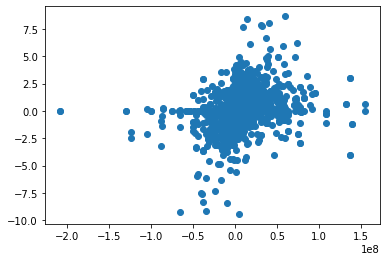

In [49]:
plt.scatter(Xtrain_NN[["value delta"]].values,ytrain_NN.values)